In [7]:
import matplotlib.pyplot as plt
import numpy as np
from misc.Datamodule import DataModule
from misc.load_model import load_model
from misc.load_df import preprocess, load_df
from misc.load_df import load_df
from misc.utils import get_closest_values
import numpy as np
import scipy.integrate as integrate
import seaborn as sns
import torch
import os


sns.set_theme()
results_dir = "Results"
data_dir = "../datasets"


save = True
outdir = "/home/rodrigo/Desktop/McGill/Research/MSc_Thesis/Figures/Modelling"
local_dir = "./Plots"
os.makedirs(local_dir, exist_ok=True)
export_plots = True


proj_dirs = ["rate_modelling", "rate_integrating"]
which_spacing = ["logspaced", "linspaced", "both"][1]
method = 0

P = 100
T = 0.356

K = 0.5  # in units of P
include_data = True
if include_data:
    df = load_df(data_dir, proj_dirs[0], method, which_spacing)
    P, K, T = get_closest_values(df, P, K, T)
else:
    K *= P
# K no longer in units of P
print(f"Using P= {P} T= {T} K = {K}")


h_dim = 64
n_layers = 6

# Rate Modelling
proj_dir = proj_dirs[0]
rate_dm = DataModule(method, proj_dir, data_dir, results_dir, which_spacing)
rate_model = load_model(
    method,
    h_dim,
    n_layers,
    proj_dir,
    rate_dm,
    saved=True,
    results_dir=results_dir,
    spacing=which_spacing,
)

# # Rate Integrating
t = 20.0
a = 0.01
b = 0.99
N_pts = 50

h_dim = 64
n_layers = 4
proj_dir = proj_dirs[1]
int_dm = DataModule(method, proj_dir, data_dir, results_dir, which_spacing)
int_model = load_model(
    method,
    h_dim,
    n_layers,
    proj_dir,
    int_dm,
    saved=True,
    results_dir=results_dir,
    spacing=which_spacing,
)

Using P= 94.912 T= 0.367 K = 47.456

    Loading rate_modelling Model 0 with 2.220000%% error
        

    Loading rate_integrating Model 0 with 1.920000%% error
        


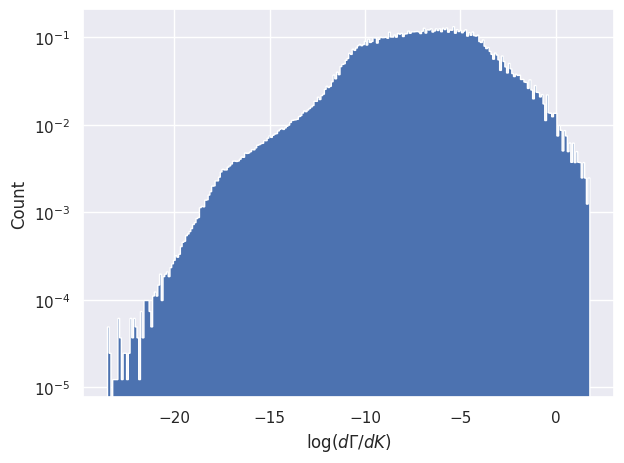

In [2]:
# for method in range(4):
#     df = preprocess('../datasets', method, which_spacing)
#     sns.displot(df, x='P', log_scale=(True, False))
#     sns.displot(df, x='K', log_scale=(True, False))
#     sns.displot(df, x='T', log_scale=(False, False))
#     sns.displot(df, x='t', log_scale=(False, False))

# fig, axes = plt.subplots(1, 2)
# df = load_df('../datasets', 'rate_integrating', method, which_spacing)
# sns.displot(df, x='Integral', log_scale=(True, True), ax=axes[1])

sns.set_theme()
gammas = load_df("../datasets", "rate_modelling", method, which_spacing)["gamma"].values
fig, axs = plt.subplots(1, 1)
axs.set_ylabel("Count")
axs.set_xlabel(r"$ \log(d\Gamma/dK$)")
axs.hist(np.log(gammas), log=(True), bins="auto", histtype="stepfilled", density=True)
plt.tight_layout()
plt.savefig(os.path.join(local_dir, "gamma_hist.png"))
plt.show()

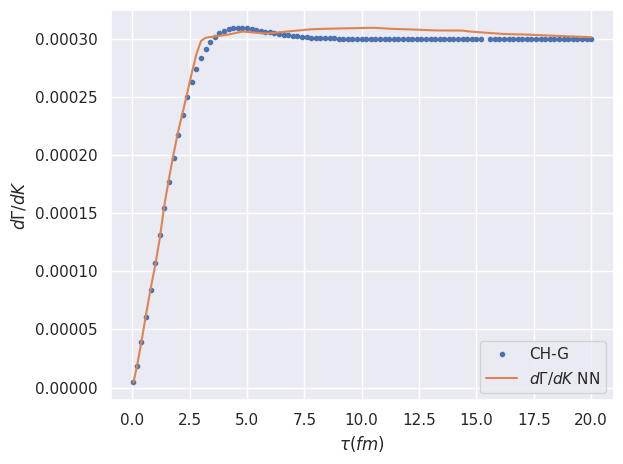

In [8]:
def compare_with_data(P, K, T, datapath, method, model, include_data=True, N=50):
    data_gam = None
    if include_data:
        df = load_df(datapath, "rate_modelling", method, which_spacing)
        subset = df[(df["P"] == P) & (df["K"] == K) & (df["T"] == T)]
        subset = subset.drop(["M"], axis=1).sort_values("t", ascending=True)
        data_gam = subset["gamma"]
        X = subset[["P", "K", "T", "t"]].values
        X = torch.tensor(X).type(torch.float)
        t = subset["t"].values
    else:
        X = torch.zeros(N, 4)
        X[:, 0] = P
        X[:, 1] = K
        X[:, 2] = T
        X[:, 3] = torch.linspace(0, 30, N)
        t = X[:, -1].clone()

    pred = model(X).detach().squeeze().numpy()
    return t, pred, data_gam


include_data = True
# include_data = False

ts, pred_t, data_t = compare_with_data(
    P, K, T, data_dir, method, rate_model, include_data=include_data
)
fig, axs = plt.subplots(1, 1)
axs.set_xlabel(r"$\tau (fm)$")
axs.set_ylabel(r"$d \Gamma / dK$")
if include_data:
    axs.plot(ts, data_t, label="CH-G", linestyle="", marker=".")
    err = ((pred_t - data_t) / data_t).abs().mean() * 100
else:
    axs.set_title(f"p = {P}, k={K}, T={T}")
axs.plot(ts, pred_t, label=r"$d\Gamma/dK$ NN")
plt.tight_layout()

plt.legend()
if save:
    plt.savefig(os.path.join(local_dir, "rate_model_t.png"), transparent=True)
plt.show()

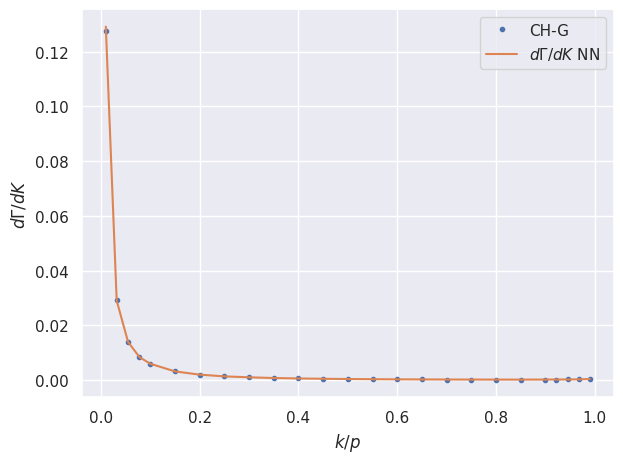

In [4]:
def compare_k_preds(P, T, t, datapath, method, model, a, b, N=50, include_data=True):
    data_gam = None
    if include_data:
        # Data
        df = load_df(datapath, "rate_modelling", method, which_spacing)
        subset = df[(df["P"] == P) & (df["T"] == T) & (df["t"] == t)]
        subset = subset.drop(["M"], axis=1).sort_values("K", ascending=True)
        data_gam = subset["gamma"]
        X = subset[["P", "K", "T", "t"]].values
        X = torch.tensor(X).type(torch.float)
        ks = subset["K"].values
    else:
        ks = torch.linspace(a, b, N) * P
        X = torch.zeros(N, 4)
        X[:, 0] = P
        X[:, 1] = ks
        X[:, 2] = T
        X[:, 3] = t
        ks = X[:, 1].clone()
    pred_gam = model(X).detach().squeeze().numpy()
    return ks, pred_gam, data_gam


ks, pred_k_gam, data_k_gam = compare_k_preds(
    P, T, t, data_dir, method, rate_model, a, b, N=N_pts, include_data=include_data
)

fig, axs = plt.subplots(1, 1)
axs.set_ylabel(r"$d \Gamma/dK$")
if include_data:
    axs.plot(ks / P, data_k_gam, label="CH-G", linestyle="", marker=".")
    err = ((pred_k_gam - data_k_gam) / data_k_gam).abs().mean() * 100
    # axs.set_title(f'p = {P}, t={t}, T={T}, error = {err:.2f}%')
    # err = ((pred_k_gam-data_k_gam)/data_k_gam)*100
    # axs[1].plot(ks/P, err)
else:
    axs.set_title(f"p = {P}, t={t}, T={T}")
axs.plot(ks / P, pred_k_gam, label=r"$d\Gamma/dK$ NN")
axs.set_xlabel(rf"$k/p$")
plt.tight_layout()
plt.legend()
if save:
    plt.savefig(os.path.join(local_dir, "rate_model_k.png"), transparent=True)
plt.show()

/home/rodrigo/.pyenv/versions/3.10.2/envs/martini_venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.126727e-05
  warnings.warn(
/home/rodrigo/.pyenv/versions/3.10.2/envs/martini_venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.312624e-04
  warnings.warn(
/home/rodrigo/.pyenv/versions/3.10.2/envs/martini_venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.772910e-04
  warnings.warn(
/home/rodrigo/.pyenv/versions/3.10.2/envs/martini_venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.846130e-04
  warnings.warn(
/home/rodrigo/.pyenv/versions/3.10.2/envs/martini_venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. 

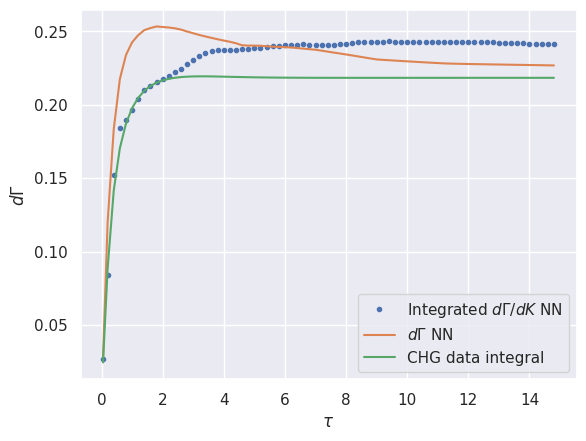

In [5]:
def k_integral(P, T, datapath, method, rate_model, int_model, a, b, N=50):
    df = load_df(datapath, "rate_modelling", method, which_spacing)
    df = df[(df["P"] == P) & (df["T"] == T)].sort_values("t", ascending=True)
    ts = df["t"].unique()
    ts = ts[ts < 15]
    gams_data = np.zeros(len(ts))
    gams_rate_model = np.zeros(len(ts))
    gams_int_model = np.zeros(len(ts))
    for idx, t in enumerate(ts):
        # Data
        subset = df[(df["P"] == P) & (df["T"] == T) & (df["t"] == t)]

        subset = subset.drop(["M"], axis=1).sort_values("K")

        x, y = subset["K"], subset["gamma"]
        gams_data[idx] = integrate.simpson(y, x=x)

        # Model
        gams_int_model[idx] = (
            int_model(torch.tensor([[P, T, t]]).type(torch.float))
            .detach()
            .squeeze()
            .numpy()
        )

        def func(k):
            k = torch.tensor(k)
            X = torch.zeros(len(k), 4)
            X[:, 0] = P
            X[:, 1] = k
            X[:, 2] = T
            X[:, 3] = t
            return np.array(rate_model(X).detach().squeeze())

        gams_rate_model[idx] = integrate.quadrature(func, a * P, b * P)[0]
    return gams_data, gams_rate_model, gams_int_model, ts


gams_data, gams_rate_model, gams_int_model, ts = k_integral(
    P, T, data_dir, method, rate_model, int_model, a, b, N=N_pts
)
plt.plot(
    ts, gams_rate_model, label=r"Integrated $d\Gamma/dK$ NN", linestyle="", marker="."
)
plt.plot(ts, gams_int_model, label=r"$d\Gamma$ NN")
plt.plot(ts, gams_data, label="CHG data integral")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$d\Gamma$")
plt.legend()
if save:
    plt.savefig(os.path.join(local_dir, "rate_model_int.png"), transparent=True)
plt.show()

In [6]:
from distutils.dir_util import copy_tree

if export_plots:
    print(os.listdir(local_dir))
    copy_tree(local_dir, outdir)

['gamma_hist.png', 'rate_model_int.png', 'rate_model_k.png', 'rate_model_t.png']


/tmp/ipykernel_466137/1085670214.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.dir_util import copy_tree
